## Analysing & Modeling Gentrification Trends in New York City

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
from matplotlib import pyplot as plt
import seaborn                   #for plotting graphs
from splot import esda as esdaplot
from scipy.spatial.distance import cdist, pdist
import plotly.graph_objects as go #for plotting graphs
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
import rioxarray                 # Surface data manipulation
import xarray                    # Surface data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights    # Spatial weights
import contextily 

/Users/sonamsonam/opt/anaconda3/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Data is obtained from US Census data for years 2012 and 2019 to do spatial analysis to measure NYC gentrification. 

Our main goal is to identify, characterise and locate neighborhoods in New York City which have undergone recent gentrification and to explore the neighborhoods which are likely to be next in line.

In [2]:
#Read data from CSV 
data_2012 = pd.read_csv('data_2012.csv', usecols = ['GEOID', 'm_income','m_rent','m_own','perc_white','perc_poverty','perc_o25_ed','owner_occ','rent_occ','rent_vac','temp_vac'])                       
data_2019 = pd.read_csv('data_2019.csv', usecols = ['GEOID', 'm_income','m_rent','m_own','perc_white','perc_poverty','perc_o25_ed','owner_occ','rent_occ','rent_vac','temp_vac'])
                        

In [3]:
#renaming the existing names
dict_rename = {'m_income':'median_HH_income','m_rent':'median_rent','m_own':'median_val_own_prop'} 
# call rename () method
data_2012 = data_2012.rename(columns=dict_rename).set_index("GEOID")
data_2019 = data_2019.rename(columns=dict_rename).set_index("GEOID")
#same geo-ids across years are considered for analysis
geo_ids_considered = list(set(data_2019.index.tolist()).intersection(set(data_2012.index.tolist())))
data_2012 = data_2012[data_2012.index.isin(geo_ids_considered)]
data_2019 = data_2019[data_2019.index.isin(geo_ids_considered)]

In [4]:
#Curation of data 
#imputed the Nan Values with mean of respective data
data_2012['median_HH_income'] = data_2012['median_HH_income'].fillna(data_2012['median_HH_income'].mean())
data_2012['median_rent'] = data_2012['median_rent'].fillna(data_2012['median_rent'].mean())
data_2012['median_val_own_prop'] = data_2012['median_val_own_prop'].fillna(data_2012['median_val_own_prop'].mean())
data_2019['median_HH_income'] = data_2019['median_HH_income'].fillna(data_2019['median_HH_income'].mean())
data_2019['median_rent'] = data_2019['median_rent'].fillna(data_2019['median_rent'].mean())
data_2019['median_val_own_prop'] = data_2019['median_val_own_prop'].fillna(data_2019['median_val_own_prop'].mean())

In [5]:
merged_data = data_2012

### Applying PCA on 2012 and 2019 data

In [6]:
#scaling the data to standard scaler
scaler_data = preprocessing.StandardScaler().fit(merged_data)
dataS=scaler_data.transform(merged_data) 

In [7]:
#perform PC decomposition over data
pca = PCA(1)
dataP=pca.fit_transform(dataS)
eigenvalues = pca.explained_variance_ratio_

In [8]:
print("The amount of explained variance is: {0:6.5f}".format(pca.explained_variance_ratio_[0]))

The amount of explained variance is: 0.45577


In [9]:
merged_data['gentri_score'] = dataP

In [10]:
data_2012_scored = merged_data.iloc[:len(data_2012)].reset_index()
#data_2019_scored = merged_data.iloc[len(data_2019):].reset_index()

In [11]:
data_2012_scored.rename(columns = {'gentri_score':'gentri_score_2012'}, inplace = True)
#data_2019_scored.rename(columns = {'gentri_score':'gentri_score_2019'}, inplace = True)

In [12]:
data_2012_scored.head()

,GEOID,median_HH_income,median_rent,median_val_own_prop,perc_white,perc_poverty,perc_o25_ed,owner_occ,rent_occ,rent_vac,temp_vac,gentri_score_2012
0,14000US36005000200,71250.0,1339.0,422200.0,0.005281,0.155794,0.538627,0.565068,0.327397,0.032877,0.000000,0.563449
1,14000US36005000400,75833.0,1569.0,355300.0,0.026291,0.076694,0.582715,0.647918,0.261763,0.020011,0.012439,1.507589
2,14000US36005001600,32328.0,856.0,413800.0,0.017944,0.187113,0.419403,0.200194,0.740184,0.000000,0.008725,-1.749685
3,14000US36005001900,29491.0,1152.0,335500.0,0.125620,0.382550,0.429262,0.073292,0.852174,0.033540,0.000000,-2.573787
4,14000US36005002000,22706.0,537.0,388100.0,0.007040,0.366235,0.331891,0.129665,0.821948,0.017394,0.018659,-3.241435


In [13]:
merged_scored = data_2012_scored

In [14]:
merged_scored.head()

,GEOID,median_HH_income,median_rent,median_val_own_prop,perc_white,perc_poverty,perc_o25_ed,owner_occ,rent_occ,rent_vac,temp_vac,gentri_score_2012
0,14000US36005000200,71250.0,1339.0,422200.0,0.005281,0.155794,0.538627,0.565068,0.327397,0.032877,0.000000,0.563449
1,14000US36005000400,75833.0,1569.0,355300.0,0.026291,0.076694,0.582715,0.647918,0.261763,0.020011,0.012439,1.507589
2,14000US36005001600,32328.0,856.0,413800.0,0.017944,0.187113,0.419403,0.200194,0.740184,0.000000,0.008725,-1.749685
3,14000US36005001900,29491.0,1152.0,335500.0,0.125620,0.382550,0.429262,0.073292,0.852174,0.033540,0.000000,-2.573787
4,14000US36005002000,22706.0,537.0,388100.0,0.007040,0.366235,0.331891,0.129665,0.821948,0.017394,0.018659,-3.241435


In [15]:
merged_scored['gentrification_ind'] = merged_scored['gentri_score_2012']

In [16]:
merged_scored.head()

,GEOID,median_HH_income,median_rent,median_val_own_prop,perc_white,perc_poverty,perc_o25_ed,owner_occ,rent_occ,rent_vac,temp_vac,gentri_score_2012,gentrification_ind
0,14000US36005000200,71250.0,1339.0,422200.0,0.005281,0.155794,0.538627,0.565068,0.327397,0.032877,0.000000,0.563449,0.563449
1,14000US36005000400,75833.0,1569.0,355300.0,0.026291,0.076694,0.582715,0.647918,0.261763,0.020011,0.012439,1.507589,1.507589
2,14000US36005001600,32328.0,856.0,413800.0,0.017944,0.187113,0.419403,0.200194,0.740184,0.000000,0.008725,-1.749685,-1.749685
3,14000US36005001900,29491.0,1152.0,335500.0,0.125620,0.382550,0.429262,0.073292,0.852174,0.033540,0.000000,-2.573787,-2.573787
4,14000US36005002000,22706.0,537.0,388100.0,0.007040,0.366235,0.331891,0.129665,0.821948,0.017394,0.018659,-3.241435,-3.241435


In [17]:
geo_df = gpd.read_file('geo_key.shp')
geo_df = geo_df.rename(columns={'key':'GEOID'})
merged_scored = pd.merge(merged_scored, geo_df, on=['GEOID'])

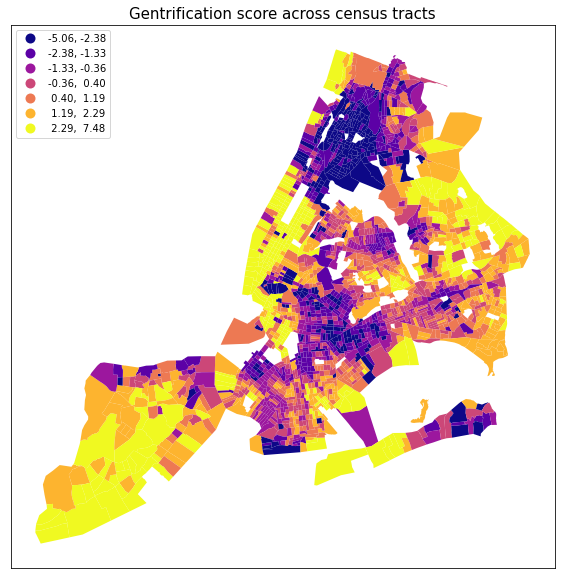

In [18]:
merged_scored= gpd.GeoDataFrame(merged_scored)
merged_scored.plot(figsize = (10,10), column='gentrification_ind', scheme='Quantiles', k=7,cmap ="plasma",legend=True,legend_kwds={'loc': 'upper left'})
plt.title("Gentrification score across census tracts", fontsize=15)
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.show()

### Stage 2

Applying local spatial statistics

In [19]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(merged_scored, k=8)
# Row-standardization
w.transform = 'R'

In [20]:
merged_scored['w_gentrification_ind'] = weights.spatial_lag.lag_spatial(w, merged_scored['gentrification_ind'])

In [21]:
merged_scored['gentrification_std'] = ( merged_scored['gentrification_ind'] - merged_scored['gentrification_ind'].mean() )
merged_scored['w_gentrification_std'] = (merged_scored['w_gentrification_ind'] - merged_scored['w_gentrification_ind'].mean() )

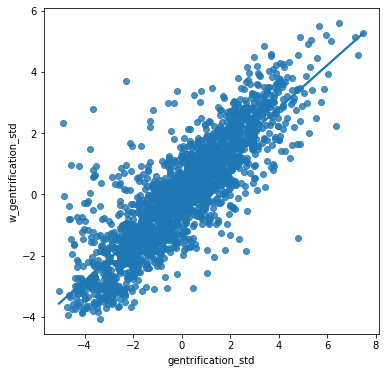

In [22]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x='gentrification_std', y='w_gentrification_std', data=merged_scored, ci=None
);

/Users/sonamsonam/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


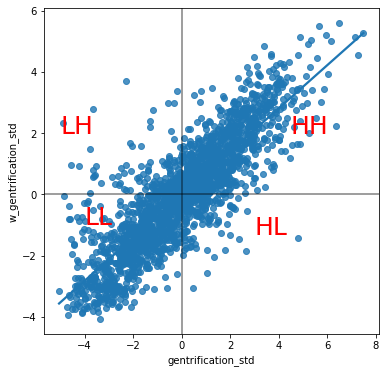

In [23]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot('gentrification_std', y='w_gentrification_std', data=merged_scored, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(4.5, 2, "HH", fontsize=25, c='r')
plt.text(3, -1.3, "HL", fontsize=25, c='r')
plt.text(-5, 2, "LH", fontsize=25, c='r')
plt.text(-4, -1.0, "LL", fontsize=25, c='r')
# Display
plt.show()

In [24]:
lisa = esda.moran.Moran_Local(merged_scored['gentrification_ind'], w)

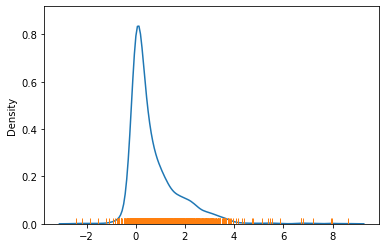

In [25]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax);

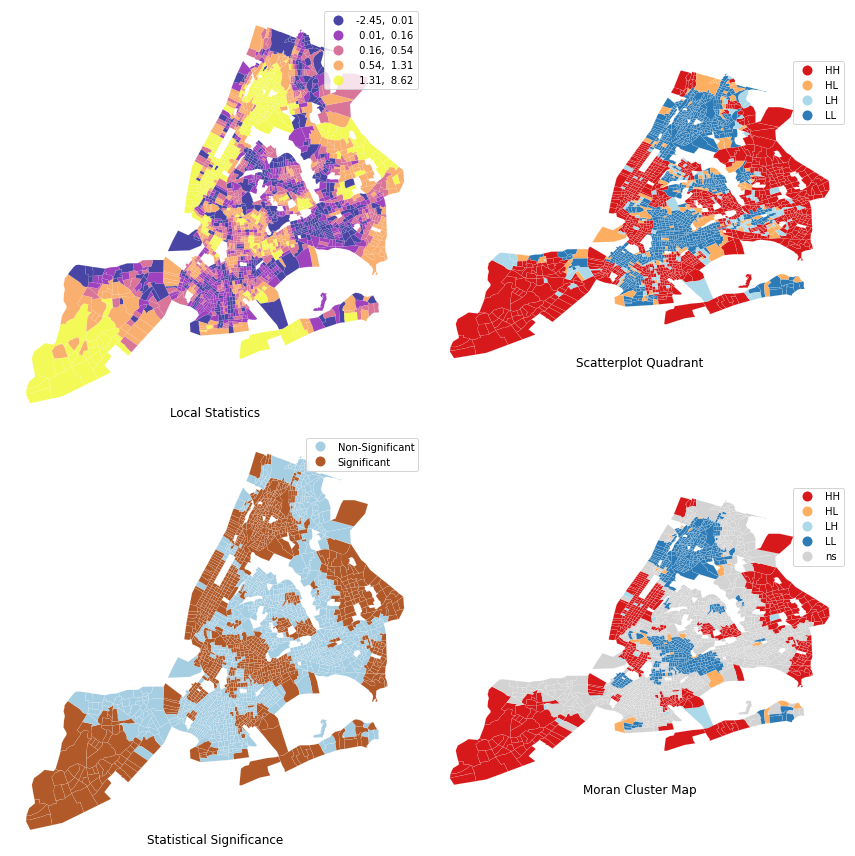

In [26]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
merged_scored.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, merged_scored, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=merged_scored.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
merged_scored.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, merged_scored, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

In [27]:
lisa.q[:10]

array([4, 4, 3, 3, 3, 3, 3, 3, 3, 3])

In [28]:
counts = pd.value_counts(lisa.q)
counts

3    893
1    892
4    171
2    153
dtype: int64

In [29]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

49.786628733997155

In [30]:
# Assign pseudo P-values to `merged_scored`
merged_scored['p-sim'] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
merged_scored['sig'] = sig
# Print top of the table to inspect
merged_scored[['sig','p-sim']].head()

,sig,p-sim
0,1,0.010
1,0,0.109
2,1,0.014
3,1,0.001
4,1,0.001


In [31]:
# Pick as part of a quadrant only significant polygons, 
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: 'Non-Significant', 1:'HH', 2: 'LH', 3:'LL', 4: 'HL'
}
# Create column in `db` with labels for each polygon
merged_scored['labels'] = pd.Series(
    # First initialise a Series using values and `db` index
    spots, index=merged_scored.index
# Then map each value to corresponding label based 
# on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
merged_scored['labels'].head()

0                 HL
1    Non-Significant
2                 LL
3                 LL
4                 LL
Name: labels, dtype: object

In [32]:
merged_scored['labels'].value_counts()

Non-Significant    1059
LL                  542
HH                  465
HL                   27
LH                   16
Name: labels, dtype: int64